# Weather in Vancouver
## Introduction
Meteorologists use data on weather patterns to predict and forecast the weather every day. They use present and past patterns and apply this knowledge to guess what will happen in the future. With apps like Apple weather and The Weather Network being used by people on a daily basis, there is clearly a need for data forecasting in our day and age as weather can affect people's moods and plans. Thus, getting the most accurate weather predictions are paramount for society.

That being said, we wanted to explore more of Vancouver (or Raincouver) to analyze weather conditions over time. We wanted to ask if we can use historical weather data in Vancouver to predict the weather label on any given day with the appropriate variables measured.

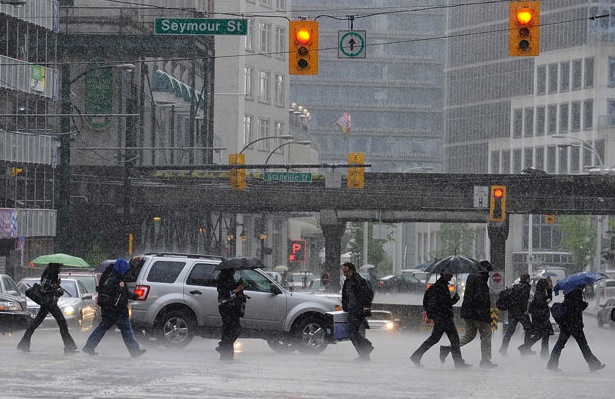

<center>Image Source: <a href="https://thisispopulist.com/tips-for-surviving-raincouver/" target="_blank">https://thisispopulist.com/tips-for-surviving-raincouver/</a></center>

In [1]:
library(tidyverse)
library(ggplot2)
library(caret)
library(GGally)
library(lubridate)
install.packages("e1071")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.1
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.0’
(as ‘lib’ is unspecified)



## Gathering and Tidying the Data
We used a dataset containing the hourly weather data from 2012-2017 which includes data from 36 US, Canadian, and Israeli cities. This data was initially found on Kaggle -- an online community of data scientists and machine learning practitioners posting datasets of all sorts for the public to use, with observations from 36 cities spread across 6 different files, which is too large a scope for the project we had been planning to undertake. It also includes its respective humidity, pressure, temperature, wind direction and wind speed for each city at a certain time. This data was collected through the use of publicly-available sources such as through the OpenWeatherMap Application Programming Interface (Beniaguev, 2017).

The initial dataset was around 80 megabytes large which was too much to handle for an environment such as the DSCI 100 server with its 100 megabyte file limit. Hence, with our supervising TA’s permission, we were able to externally filter out data irrelevant to our project -- mostly encompassing the data based in the 35 cities other than Vancouver to reduce the file size of the dataset. This data is then uploaded to a remote server so that the file is easily accessible. As shown in Figure 1, the six files are imported into R from the remote server:

In [2]:
weather_description <- read_csv("https://dsci100.ubc.phillytan.xyz/weather_description_filtered.csv") %>% 
    mutate(description = Vancouver) %>% 
    select(-Vancouver)
humidity <- read_csv("https://dsci100.ubc.phillytan.xyz/humidity_filtered.csv") %>% 
    mutate(humidity = Vancouver) %>% 
    select(-datetime, -Vancouver)
pressure <- read_csv("https://dsci100.ubc.phillytan.xyz/pressure_filtered.csv") %>% 
    mutate(pressure = Vancouver) %>% 
    select(-datetime, -Vancouver)
temperature <- read_csv("https://dsci100.ubc.phillytan.xyz/temperature_filtered.csv") %>% 
    mutate(temperature = Vancouver) %>% 
    select(-datetime, -Vancouver)
wind_direction <- read_csv("https://dsci100.ubc.phillytan.xyz/wind_direction_filtered.csv") %>% 
    mutate(wind_direction = Vancouver) %>% 
    select(-datetime, -Vancouver)
wind_speed <- read_csv("https://dsci100.ubc.phillytan.xyz/wind_speed_filtered.csv") %>% 
    mutate(wind_speed = Vancouver) %>% 
    select(-datetime, -Vancouver)

Parsed with column specification:
cols(
  datetime = col_datetime(format = ""),
  Vancouver = col_character()
)

Parsed with column specification:
cols(
  datetime = col_datetime(format = ""),
  Vancouver = col_double()
)

Parsed with column specification:
cols(
  datetime = col_datetime(format = ""),
  Vancouver = col_double()
)

Parsed with column specification:
cols(
  datetime = col_datetime(format = ""),
  Vancouver = col_double()
)

Parsed with column specification:
cols(
  datetime = col_datetime(format = ""),
  Vancouver = col_double()
)

Parsed with column specification:
cols(
  datetime = col_datetime(format = ""),
  Vancouver = col_double()
)



Due to the nature of the data originally constructed by splitting the different categories into its own files with the columns representing each city, each observation was noted as only results for one variable such as temperature. In order to obtain columns for temperature and pressure and such, we used mutate to add a column of the descriptor’s name with the data in the “Vancouver” column and used select to then remove the “Vancouver” column. In other words, we merely renamed the columns to their appropriate types.

In the case of the weather descriptions of each city at a given time (now only for Vancouver), there were far too many. For instance there were 4 different variants of descriptions of snow: light snow, medium snow, heavy snow, snow flurry. The reason why this poses a problem is that, for example, snow flurry is very rare in Vancouver, hence the scope of a predictive analysis would more often than not fail in predicting a possible snow flurry. This became clear to us when the initial accuracy of our model was only 32% due to including these rare weather conditions in our data. Hence weather categories were simplified further into simpler variants such as rain, snow, sunny, etc. as can be seen below. We also decided to group the extreme circumstances such as dust storms and volcanic ash by renaming them to just “extreme” since they’re both extreme circumstances evoking the same extreme response systems from the data’s audience in real-time. In addition, we decided to group these extreme cases together so that we could further eliminate these inconsistencies in this step before we continue processing them. We felt the need to remove these outliers since these are rare occurrences and shouldn’t influence day-to-day life.

In [3]:
weather_description <- weather_description %>%
    mutate_if(is.character, 
                str_replace_all, pattern = ".*rain", replacement = "rain") %>%
    mutate_if(is.character, 
                str_replace_all, pattern = ".*clouds", replacement = "cloudy") %>%
    mutate_if(is.character, 
                str_replace_all, pattern = ".*snow", replacement = "snow") %>%
    mutate_if(is.character, 
                str_replace_all, pattern = ".*thunderstorm", replacement = "thunderstorm") %>%
    mutate_if(is.character, 
                str_replace_all, pattern = ".*drizzle", replacement = "rain") %>%
    mutate_if(is.character, 
                str_replace_all, pattern = ".*sleet", replacement = "snow") %>%
    mutate_if(is.character, 
                str_replace_all, pattern = "sky is clear", replacement = "clear") %>%
    mutate_if(is.character, 
                str_replace_all, pattern = "dust", replacement = "extreme") %>%
    mutate_if(is.character, 
                str_replace_all, pattern = "volcanic ash", replacement = "extreme")

Once we have done this initial processing of data, we have to merge all these 6 files into one data frame. This was done through cleaning up the initial six files off NA entries and removing the extreme weather circumstances from the descriptions column, and using the cbind() function to merge them into one dataframe. We also converted the description variable into a factor since it will serve as our classification variable. Lastly, using the <code>datetime</code> column, we used R’s ‘lubridate’ library to determine the specified date’s month and replaced the <code>datetime</code> column with a new ‘month’ column instead. This is because we wanted to introduce the month of the year as a variable towards building this model.

In [4]:
data <- cbind(weather_description, humidity, pressure, temperature, wind_direction, wind_speed) %>% 
    filter(!is.na(description) & 
           !is.na(humidity) & 
           !is.na(pressure) & 
           !is.na(temperature) & 
           !is.na(wind_direction) & 
           !is.na(wind_speed) &
            description != 'extreme') %>%
    mutate(description = as.factor(description))
data <- data %>% mutate(month = month(datetime)) %>% select(-datetime)

The table below shows the data frame we finally created that would be relevant to our project:

In [5]:
head(data)

,description,humidity,pressure,temperature,wind_direction,wind_speed,month
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,cloudy,87,807,284.5902,268,0,10
2,cloudy,88,849,284.5882,281,0,10
3,cloudy,89,890,284.5861,295,0,10
4,cloudy,89,932,284.5841,309,0,10
5,cloudy,90,973,284.5820,323,0,10
6,clear,91,1015,284.5800,337,0,10


<center><b>Figure 1:</b> Final dataframe used for the rest of the project</center>

## Variables

**Description:** pertains to the descriptor of the weather at any given time in Vancouver. Since this will be the classifier in our predictive analysis project, this is present as a factor.

**Humidity:** pertains to the humidity at any given time in Vancouver. We initially proposed the idea of using this as one of our predictor variables, since we noted that while holding water content in the air as a constant, humidity and temperature share an inverse relationship with each other. This can be an interesting relationship to exploit in predicting weather conditions in relation to temperature (2013, March 5).

**Pressure:** “Rising air creates low pressure while sinking air creates high pressure.” (2018, March 11). When air rises and cools; clouds and precipitation (such as snow and rain) are formed. Low air pressure is not too much of a concern for our project since its consequences do not apply to Vancouver i.e. they haven’t occurred within the timeframe of the dataset (2012-2017).

**Temperature:** If temperature wasn’t a quantifiable variable, one could argue its importance as a classifier variable, since it depends on all the weather conditions described above and to be described below, but it in turn also serves as one of the most impactful classifiers for our analysis.

**Wind direction:** Wind can carry different temperatures of wind, and also variable humidity, between all kinds of geographical regions. These traits of wind only make wind direction only mildly important as a predictor variable, since analysts still aren’t able to accurately predict the weather based on wind direction, only severe situations such as drought, hurricanes, and such have been successfully predicted based on the wind direction in a region. Regardless, we didn’t think it insignificant enough to be omitted hence it remains in the dataset.

**Wind speed:** Another weak predictor, only really useful for predicting extreme conditions. It can, however, be useful for predicting the pressure in a region, which in turn can be useful for our analysis in some way, and so this wasn’t omitted either.

**Month:** pertains to the month of when that particular data point was collected as a number from 1 to 12. We decided to include this as a datapoint since we think that the month can greatly influence the weather conditions.

As a part of our exploratory data analysis, we used <code>ggpairs</code> to create a matrix plot among our different numerical variables to see the relationships between the different variables. This gives us preliminary insights on what kinds of variables may affect our results. In our case, there isn’t much correlation among any of the variables in our dataset since the values are all scattered around except for <code>temperature</code> and <code>month</code>. That being said, we believe that the <code>temperature</code> and <code>month</code> variables may have greater influence in our model.

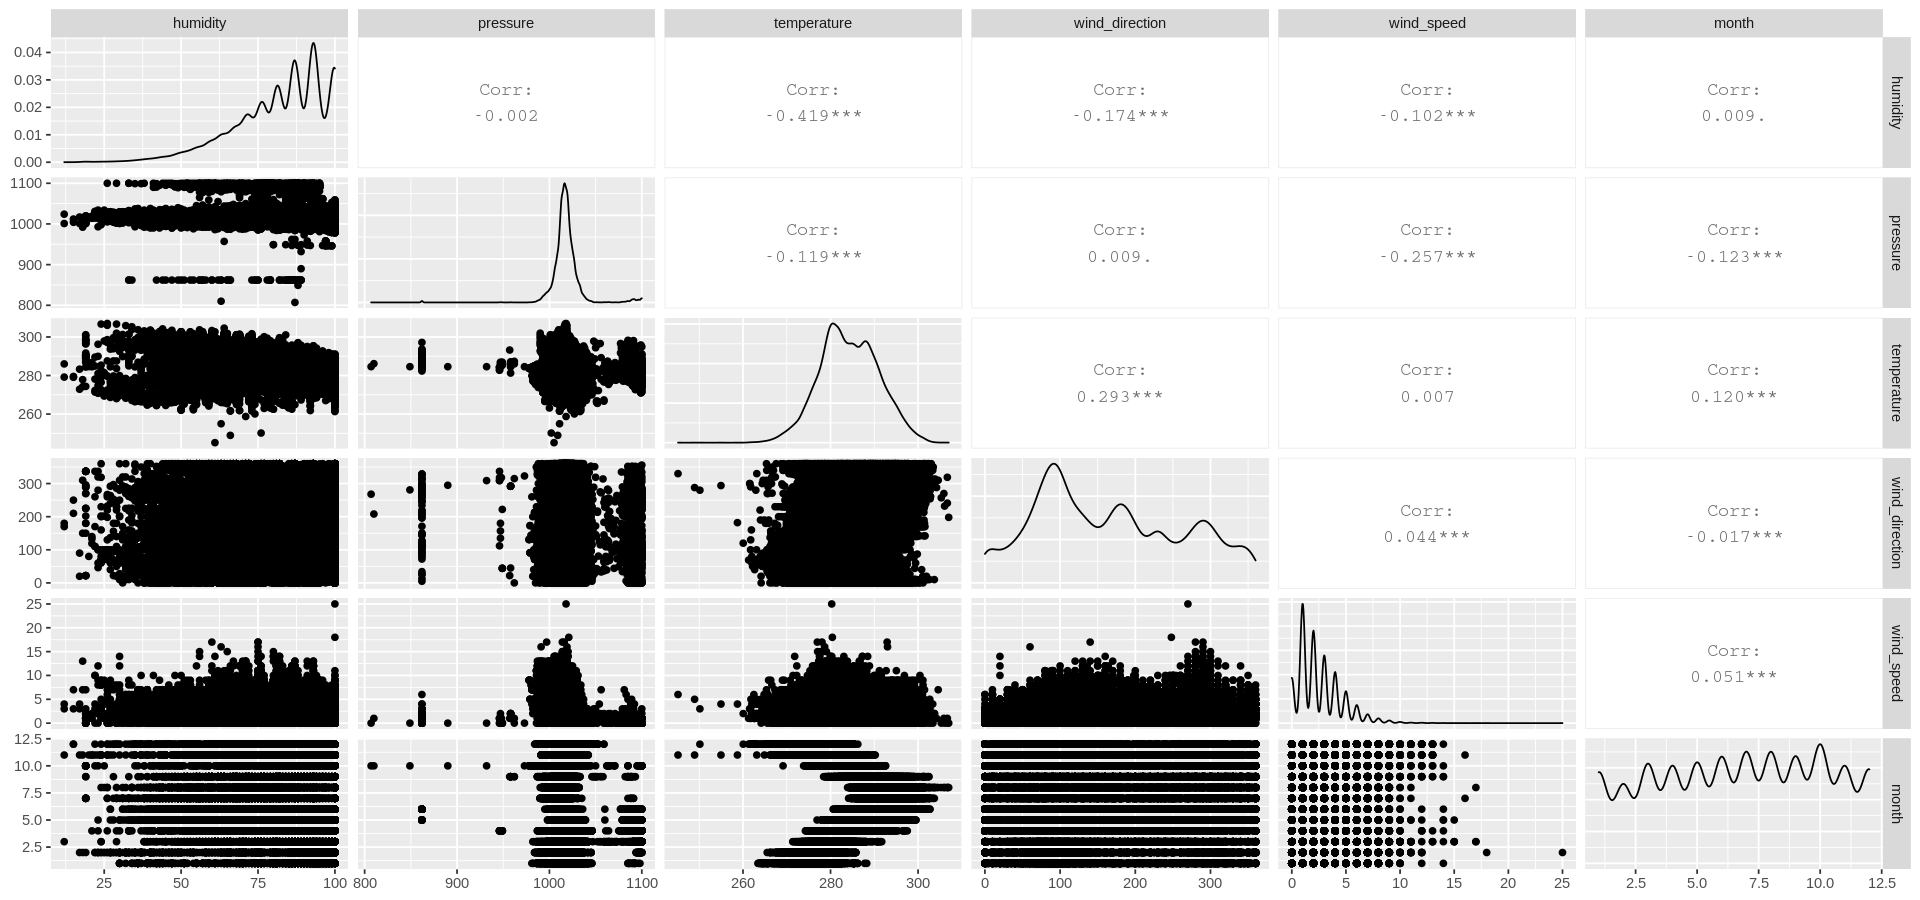

In [6]:
options(repr.plot.height = 7.5, repr.plot.width = 16)
plot_pairs <- data %>% 
    select(humidity, pressure, temperature, wind_direction, wind_speed, month) %>% 
    ggpairs()
plot_pairs

<center><b>Figure 2:</b> Matrix of scatter plots of predictor variables.</center>

## K-nn Classification

Now it was time to perform our classification analysis. While performing it, we tried many different tactics to try and increase our overall accuracy, which was our end goal as we wanted to build an accurate model. These included the following:

We trained the classifier with all the variables first to get a baseline accuracy that we could work of. This ended up being around <code>43%</code>. We then tried to remove some of the variables that we thought were weaker than others to try and increase this accuracy. We initially removed wind direction and wind speed in alternating trials and found that this did not in fact increase our accuracy that much so in the end we decided to keep all the variables.

We also trained the classifier using different sizes for the training set and testing set to find the highest accuracy of the classifier. We tried slicing the dataset into <code>50%</code>, <code>60%</code>, <code>75%</code>, and <code>85%</code> (for the training set and the remainder for the testing set) and concluded that an <code>85%</code> slice results in the highest accuracy of 49%. However, this preliminary test was excluding the month.

When we decided to add month as a variable to our dataset, we figured that similar observations in the same month would yield similar descriptions. Adding this as another variable leads to an increase in our accuracy to around <code>53%</code>.

All these changes led to the code as shown below:

k-Nearest Neighbors 

34533 samples
    6 predictor
    9 classes: 'clear', 'cloudy', 'fog', 'haze', 'mist', 'rain', 'smoke', 'snow', 'thunderstorm' 

No pre-processing
Resampling: Cross-Validated (250 fold) 
Summary of sample sizes: 34394, 34395, 34396, 34395, 34395, 34396, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   1  0.5339993  0.3705364
   3  0.5128496  0.3367868
   5  0.5146268  0.3318653
   7  0.5205763  0.3365574
   9  0.5183856  0.3313911
  11  0.5146143  0.3246711

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 1.

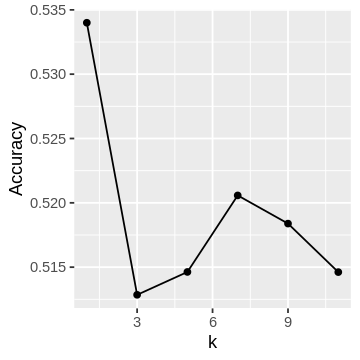

In [7]:
set.seed(3456)

training_rows <- data %>%
    select(description) %>%
    unlist() %>%
    createDataPartition(p = 0.85, list = FALSE)

training_set <- data %>% slice(training_rows)
testing_set <- data %>% slice(-training_rows)

scale_transformer <- preProcess(training_set, method = c("center", "scale")) 
training_set <- predict(scale_transformer, training_set)
testing_set <- predict(scale_transformer, testing_set)

training_data <- training_set %>% select(-description) %>% data.frame()
training_labels <- training_set %>% select(description) %>% unlist()
testing_data <- testing_set %>% select(-description) %>% data.frame()
testing_labels <- testing_set %>% select(description) %>% unlist()

k <- data.frame(k = seq(from = 1, to = 11, by = 2))
train_control <- trainControl(method = "cv", number = 250)
model_knn <- train(x = training_data, y = training_labels, method="knn", tuneGrid = k, trControl = train_control)
model_knn

options(repr.plot.height = 3, repr.plot.width = 3)
accuracies_lots <- model_knn$results
accuracy_vs_k_lots <- ggplot(accuracies_lots, aes(x = k, y = Accuracy)) +
  geom_point() +
  geom_line()
accuracy_vs_k_lots

<center><b>Figure 3:</b> Output from KNN Model and graph showing different K's and their respective accuracies.</center>

In addition, we decided to choose <code>K = 1</code> because that's the <code>K</code> that yields the best accuracy while setting our train control to <code>250</code> when testing from <code>K = 1</code> to <code>51</code> with intervals of <code>2</code>. We decided to leave train control set to <code>250</code> folds mainly because we’d be training the dataset against around 34,000 data points. Hence, using cross-validation would yield a much accurate result with a dataset of this magnitude.

In [8]:
# testing_data

k <- data.frame(k = 1)
train_control <- trainControl(method = "cv", number = 250)
model_knn <- train(x = training_data, y = training_labels, method="knn", tuneGrid = k, trControl = train_control)
model_knn

k-Nearest Neighbors 

34533 samples
    6 predictor
    9 classes: 'clear', 'cloudy', 'fog', 'haze', 'mist', 'rain', 'smoke', 'snow', 'thunderstorm' 

No pre-processing
Resampling: Cross-Validated (250 fold) 
Summary of sample sizes: 34396, 34395, 34394, 34394, 34395, 34395, ... 
Resampling results:

  Accuracy   Kappa    
  0.5342562  0.3708653

Tuning parameter 'k' was held constant at a value of 1

To test our trained model, we decided to use our <code>testing_data</code> as input towards our model in order to get its quality. We used the predict function to predict the <code>testing_data</code> against our trained model and used <code>confusionMatrix</code> to determine its accuracy. We discovered that through our model, we were able to get around <code>54%</code> accuracy against our test dataset.

In [9]:
testing_predicted <- predict(object = model_knn, testing_data)
testing_model_quality <- confusionMatrix(data = testing_predicted, reference = testing_labels)
testing_model_quality

Confusion Matrix and Statistics

              Reference
Prediction     clear cloudy  fog haze mist rain smoke snow thunderstorm
  clear         1155    380   32   15   61  170     8   20            0
  cloudy         328   1165   53   17  118  346     7   30            2
  fog             34     37   43    1   31   38     1    2            0
  haze            30     25    0   16    1    7     0    0            0
  mist            68     92   37    1  145  102     0    5            0
  rain           171    288   44    7  107  734     2   14            0
  smoke           11      3    0    1    1    2     9    0            0
  snow            12     13    5    1    6   11     1   20            0
  thunderstorm     0      0    0    0    2    1     0    0            0

Overall Statistics
                                          
               Accuracy : 0.5398          
                 95% CI : (0.5272, 0.5524)
    No Information Rate : 0.329           
    P-Value [Acc > NIR] : < 2.2

## Analysis

The graph below partitions data predicted by our model and the actual data from the testing set we initially created in order to provide a visual representation of the relative accuracy of our model. For instance, in the case of the classification for clear weather, we predicted that incorrectly about <code>40%</code> of the time. We decided to use this graph as a measure of how accurate our model is in predicting the different weather descriptors.

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



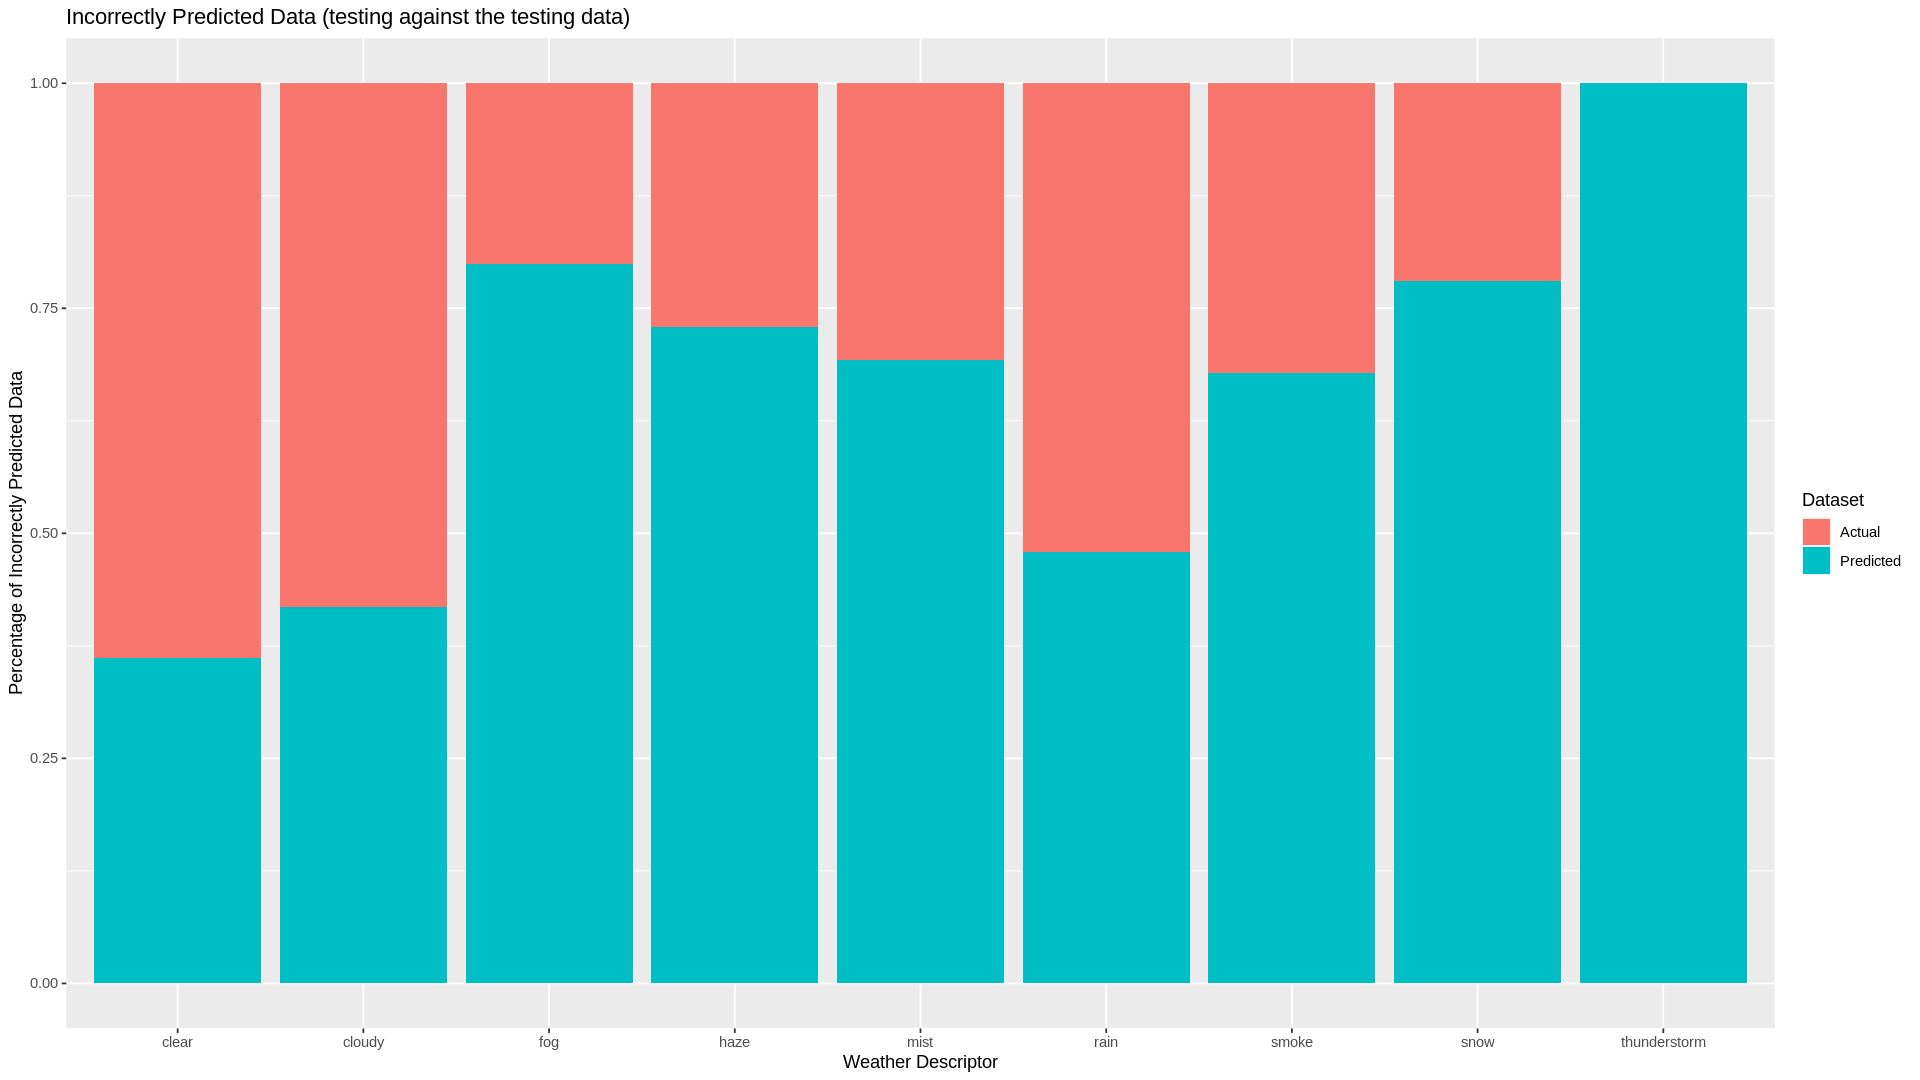

In [10]:
test_actual <- testing_labels %>% data.frame()
test_predict <- testing_predicted %>% data.frame()

colnames(test_actual) <- c("actual")
colnames(test_predict) <- c("predicted")

incorrectly_predicted <- cbind(test_actual, test_predict) %>% 
    filter(actual != predicted) %>% 
    group_by(actual) %>% 
    summarize(predicted_count = n()) %>%
    mutate(descriptor = actual) %>%
    select(-actual)
actual_counts <- test_actual %>% 
    group_by(actual) %>% 
    summarize(actual_count = n()) %>%
    select(-actual)
combined_c <- cbind(incorrectly_predicted, actual_counts) %>% 
    mutate(actual_count = actual_count - predicted_count) # for graphing purposes
incorrectly_predicted <- combined_c %>% 
    select(descriptor, predicted_count) %>%
    mutate(count = predicted_count) %>% 
    select(-predicted_count) %>% 
    mutate(dataset="Predicted")
actual_counts <- combined_c %>% 
    select(descriptor, actual_count) %>%
    mutate(count = actual_count) %>% 
    select(-actual_count) %>% 
    mutate(dataset="Actual")
combined <- rbind(incorrectly_predicted, actual_counts)

options(repr.plot.height = 9, repr.plot.width = 16)
ggplot(combined, aes(x=descriptor, count, fill=dataset)) +
    geom_bar(stat="identity", position="fill") +
    labs(x="Weather Descriptor",
         y="Percentage of Incorrectly Predicted Data",
         fill="Dataset",
         title="Incorrectly Predicted Data (testing against the testing data)")

<center><b>Figure 4:</b> Incorrectly Predicted Data (testing against the testing data)</center>

## Discussion
Our classifier had a final accuracy of around <code>54%</code> when used on our test data. This was the result of trying several combinations of our variables and finding which combination results in the highest accuracy. Since our initial visualisation illustrated a clear weather pattern throughout the year, we were expecting our final accuracy to be higher than what we got. This difference can explain why weather forecasts are rarely <code>100%</code> accurate. There are many factors that contribute to identifying, determining, and classifying weather conditions during specific periods of the year, some of which only occur rarely, such as volcano eruptions which can lead to lots of smoke and dust, therefore weather forecasts are only able to predict these conditions to a certain accuracy. Moreover, to some certain extent, weather descriptors can be subjective relative to the forecaster’s precise location.

This classification leads us to question what other variables professionals use to classify the weather on an upcoming day? Using what combination of variables might result in higher accuracies?

## Conclusion
In conclusion, we can use historical data as a means for predicting weather descriptors to a certain extent. Even with an accuracy above <code>50%</code>, it is still not feasible enough for real-world use. Moreover, weather descriptors can be subjective relative to one's location so another area in the same city could definitely yield different results. However, that doesn't mean that this can be used for experimental purposes or even for statistical analysis. Granted it is an interesting topic to look into, professionals would have to incorporate more variables than what we currently have at the moment to accurately predict weather.

## References
Beniaguev, D. (2017, December 27). Historical Hourly Weather Data 2012-2017. Hourly Weather Data for 30 US & Canadian Cities + 6 Israeli Cities. https://kaggle.com/selfishgene/historical-hourly-weather-data

Humidity. (2013, March 5). Retrieved April 6, 2020, from https://climate.ncsu.edu/edu/Humidity

Johnson, R. L. (2018, March 11). How Does Air Pressure Affect Weather? Retrieved April 6, 2020, from https://the-weather-station.com/how-does-air-pressure-affect-weather/